In [1]:
%run ../talktools.py

[Run on Colab](https://colab.research.google.com/github/profjsb/python-seminar/blob/master/DataFiles_and_Notebooks/07_machine_learning_2/03_classification_and_CNNs_with_keras.ipynb)

# Classification with Keras

*AY 250 (UC Berkeley, 2012-2022)*

We've just seen regression problems with neural nets in `keras`. Let's now explore classification, on images. Let's introduce the [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist#labels) dataset: 70k small (28$\times$28) images of 10 different types of clothing.

<img src="https://github.com/zalandoresearch/fashion-mnist/blob/master/doc/img/fashion-mnist-sprite.png?raw=true" width="80%">

Each training and test example is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

Tensorflow has a simple method to get this data locally

In [2]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [3]:
import datetime, os
import numpy as np
import warnings

# from IPython.external import mathjax

import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Activation, BatchNormalization
)
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
# Print keras version
print("Using tensorflow version:", tensorflow.keras.__version__)

Using tensorflow version: 2.8.0


In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # scale the images to 0-1

In [5]:
x_train.shape

(60000, 28, 28)

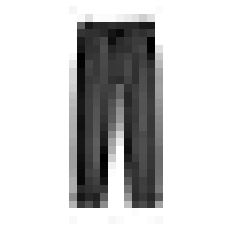

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

ind = 21
plt.axis('off')
_ = plt.imshow(x_train[ind], cmap=plt.cm.gray_r, interpolation='nearest')

To learn a model to predict the class of a given image, we could treat this 28$\times$28 image as 1d input, like a stellar spectrum:

Text(0.5, 0, '1D pixel index')

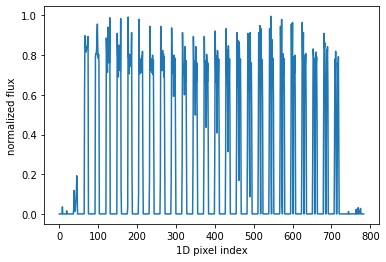

In [7]:
_ = plt.plot(x_train[ind].reshape(-1))
plt.ylabel("normalized flux")
plt.xlabel("1D pixel index")

But this *clearly* jumbles the inherent spatial structure and local correlations found in natural images. Using just Dense layers in a NN we'd effectively be asking the network to learn these correlations.

## Convolutional Neural Nets (ConvNets)

NNs built for images (or more generally, inputs with spatial structure).

### Key Ideas: 
  - layers see only parts of each image (effectively all other weights are zero).
  - some layers do simple operations on previous layers to reduce dimensionality (e.g., take the largest value in a a 3x3 range)
  - "Every Layer has a simple API: It transforms an input 3D volume to an output 3D volume with some differentiable function that may or may not have parameters."
 
<img src="http://cs231n.github.io/assets/cnn/cnn.jpeg">

<img src="http://cs231n.github.io/assets/cnn/depthcol.jpeg">

"An example input volume in red (e.g. a 32x32x3 CIFAR-10 image), and an example volume of neurons in the first Convolutional layer. Each neuron in the convolutional layer is connected only to a local region in the input volume spatially, but to the full depth (i.e. all color channels). Note, there are multiple neurons (5 in this example) along the depth, all looking at the same region in the input - see discussion of depth columns in text below. "

cf. http://cs231n.github.io/convolutional-networks/

<img src="data/f2.png">
Source: http://www.nature.com/nature/journal/v521/n7553/fig_tab/nature14539_F2.html

### Filter banks

  http://setosa.io/ev/image-kernels/

### Pooling

<img src="http://cs231n.github.io/assets/cnn/pool.jpeg" width="40%">
<img src="http://cs231n.github.io/assets/cnn/maxpool.jpeg" width="40%">
Source: http://cs231n.github.io/convolutional-networks/

In [8]:
from tensorflow.keras.utils import to_categorical

nb_classes = 10
batch_size = 128

# convert class vectors to binary class matrices
Y_train =  to_categorical(y_train, nb_classes)
Y_test =  to_categorical(y_test, nb_classes)

input_shape = x_train[0].shape  + (1,)
input_shape

(28, 28, 1)

In [9]:
Y_train

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

We want our output predictions to look like a "probability" of belonging to one of the 10 classes. And, importantly, we'd like to make sure that the probability over all classes sums to unity. One way to do this is to scale the outputs of the last layer using a [`softmax`](https://en.wikipedia.org/wiki/Softmax_function):

$$
{\rm softmax}(\vec s) = \frac{e^{s_i}}{\sum_i e^{s_i}}
$$

So if the (unnormalized) prediction from am NN for an image is:

In [10]:
s = np.random.normal(size=(10,))
s

array([-1.70803733, -0.2451512 ,  0.94326044,  0.59330822,  0.39485066,
        0.28890328,  2.74353598, -1.77755516, -0.74714626, -1.19263856])

Then the softmax scaling gives us:

In [11]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

print(softmax(s))
np.testing.assert_almost_equal(softmax(s).sum(), 1.0)

[0.00735199 0.03174886 0.10419544 0.0734288  0.06021121 0.0541583
 0.6305194  0.00685825 0.01921828 0.01230948]


In [12]:
from scipy.special import softmax as sp_softmax
sp_softmax(s)

array([0.00735199, 0.03174886, 0.10419544, 0.0734288 , 0.06021121,
       0.0541583 , 0.6305194 , 0.00685825, 0.01921828, 0.01230948])

We'll use the "categorical cross-entropy" loss:

<img src="https://gombru.github.io/assets/cross_entropy_loss/softmax_CE_pipeline.png">
Source: https://gombru.github.io/2018/05/23/cross_entropy_loss/

In [13]:
# perfect match ... use a small ϵ to avoid taking log(0) since lim x log x -> 0 as x->0
print("loss with a perfect match:", -(Y_train[0] @ np.log(Y_train[0] + 1e-16)))
print("loss with a predicted match:", -(Y_train[0] @ np.log(softmax(s) + 1e-16)))

loss with a perfect match: -0.0
loss with a predicted match: 4.397385891269085


## Building a CNN

In [14]:
# add with tf.device('/gpu:0'): if on GPU

with tf.device('/gpu:0'):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3,3), input_shape=input_shape))
    model.add(Activation('relu'))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))

    model.add(Dense(32, activation='relu'))


    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 26, 26, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 11, 11, 64)        0

In [16]:
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [17]:
run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')
# define path to save model
model_path = f'nn_results/ay250_nn_{run_time_string}.h5'
print(f"Training ... {model_path}")

logdir = os.path.join("nn_results", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.75,
                              patience=2, min_lr=1e-6, verbose=1, cooldown=0)

csv_logger = tf.keras.callbacks.CSVLogger(f'nn_results/training_{run_time_string}.log')

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, 
                                             patience=3, \
                                             verbose=1, mode='auto')

model_check = tf.keras.callbacks.ModelCheckpoint(model_path,
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max',
        verbose=1)

model.fit(x=x_train.reshape(-1,28,28,1), 
          y=Y_train, 
          epochs=20,
          batch_size=batch_size,
          validation_data=(x_test.reshape(-1,28,28,1), Y_test), 
          callbacks=[tensorboard_callback, reduce_lr, csv_logger, earlystop, model_check])

Training ... nn_results/ay250_nn_2022-04-04T22:38.h5
Epoch 1/20
468/469 [============================>.] - ETA: 0s - loss: 0.4882 - accuracy: 0.8235
Epoch 1: val_accuracy improved from -inf to 0.86360, saving model to nn_results/ay250_nn_2022-04-04T22:38.h5
469/469 [==============================] - 8s 16ms/step - loss: 0.4880 - accuracy: 0.8235 - val_loss: 0.4180 - val_accuracy: 0.8636 - lr: 0.0010
Epoch 2/20
467/469 [============================>.] - ETA: 0s - loss: 0.3098 - accuracy: 0.8890
Epoch 2: val_accuracy improved from 0.86360 to 0.89190, saving model to nn_results/ay250_nn_2022-04-04T22:38.h5
469/469 [==============================] - 7s 16ms/step - loss: 0.3095 - accuracy: 0.8891 - val_loss: 0.2973 - val_accuracy: 0.8919 - lr: 0.0010
Epoch 3/20
466/469 [============================>.] - ETA: 0s - loss: 0.2647 - accuracy: 0.9040
Epoch 3: val_accuracy did not improve from 0.89190
469/469 [==============================] - 7s 16ms/step - loss: 0.2651 - accuracy: 0.9039 - val_l

### Aside: Dropout 

You'll notice above that the `accuracy` is much higher than the `val_accuracy`. That is, we overfit on the training data. One way to help protect against this is to introduce `Dropout`

<img src="https://cdn-images-1.medium.com/max/1600/1*iWQzxhVlvadk6VAJjsgXgg.png">

Srivastava, Nitish, et al. ”Dropout: a simple way to prevent neural networks from
overfitting”, JMLR 2014

```python
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.1)) # 10% of dropping an output connection
```

### Aside: Visualization of the layers

From François Chollet (“DEEP LEARNING with Python”):

Intermediate activations are “useful for understanding how successive convnet layers transform their input, and for getting a first idea of the meaning of individual convnet filters.”

“The representations learned by convnets are highly amenable to visualization, in large part because they’re representations of visual concepts. Visualizing intermediate activations consists of displaying the feature maps that are output by various convolution and pooling layers in a network, given a certain input (the output of a layer is often called its activation, the output of the activation function). This gives a view into how an input is decomposed into the different filters learned by the network. Each channel encodes relatively independent features, so the proper way to visualize these feature maps is by independently plotting the contents of every channel as a 2D image.”

Following from https://github.com/gabrielpierobon/cnnshapes/blob/master/README.md

In [19]:
layer_outputs = []
layer_names = []
for layer in model.layers:
    keep = True
    for t in ["dropout", "normalization", "flatten", "dense", "activation"]:
        if layer.name.find(t) != -1:
            keep = False
    if keep:
        layer_outputs.append(layer.output)
        layer_names.append(layer.name) 
        
activation_model = tensorflow.keras.models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(x_test[0].reshape(1,28,28,1)) # Returns a list of five Numpy arrays: one array per layer activation

In [20]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 26, 26, 32)


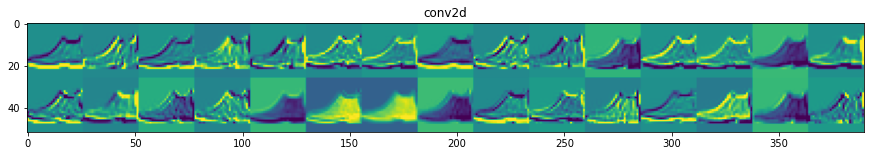

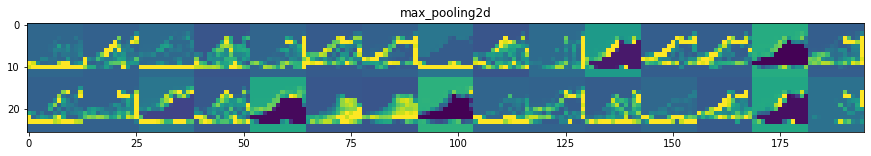

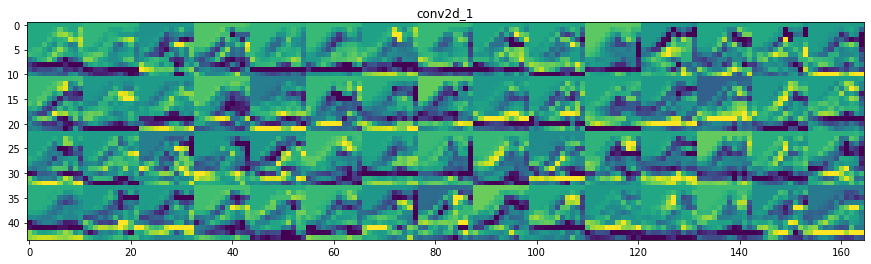

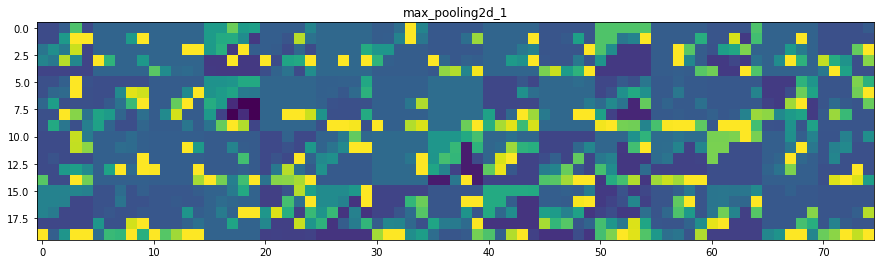

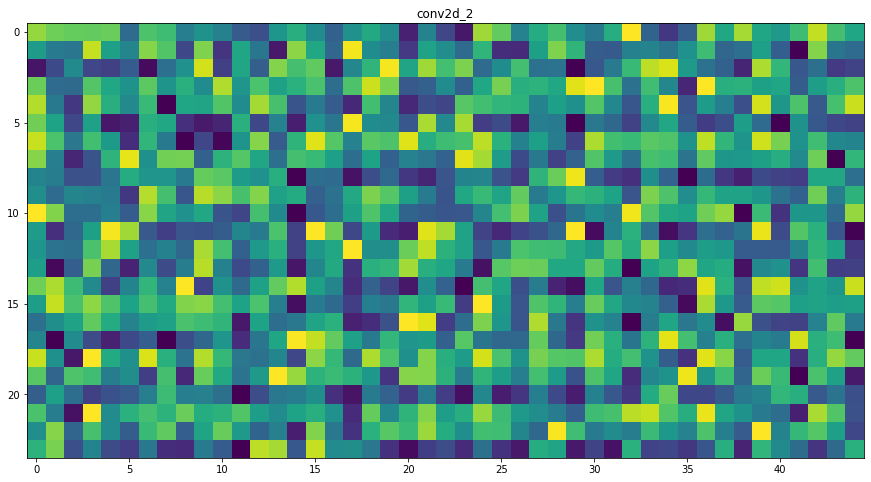

In [21]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

images_per_row = 15

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1]   # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

# Data Augmentation

Another way to avoid overfitting, aside from `Dropout`, is to increase the number of exmaples used to to train the model.  Data augmentation is a generic term for methods used to expand the effect training set size by generating more data from the original training set. In images, this is pretty natural: scale changes, rotations, flips, etc. should still give us the same label. This method has the benefit of usually increasing test-time accuracy.

<img src="https://cdn-images-1.medium.com/max/1200/1*C8hNiOqur4OJyEZmC7OnzQ.png">

In keras we can use the `ImageDataGenerator`. In Pytorch see https://pytorch-lightning.readthedocs.io/en/stable/extensions/datamodules.html

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# creating the data aumentation genreators for both the training images and the training label masks
data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=15.,
                     rescale=1.0,
                     shear_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     fill_mode = 'nearest')

image_datagen = ImageDataGenerator(**data_gen_args)

seed = 42
batch_size = 256


(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # scale the images to 0-1

# convert class vectors to binary class matrices
Y_train =  to_categorical(y_train, nb_classes)
Y_test =  to_categorical(y_test, nb_classes)

input_shape = x_train[0].shape  + (1,)

image_generator = image_datagen.flow(
    np.expand_dims(x_train, axis=3),  Y_train,
    shuffle = True,
    batch_size=batch_size,
    seed=seed)

In [ ]:
ImageDataGenerator?

In [23]:
type(image_generator)

keras.preprocessing.image.NumpyArrayIterator

In [24]:
rez = image_generator.next()

In [27]:
rez[0].shape

(256, 28, 28, 1)

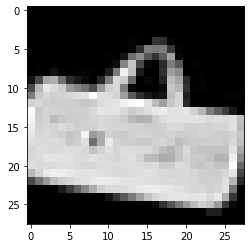

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(rez[0][4][:,:,0], cmap='gray')

In [30]:
# add with tf.device('/gpu:0'): if on GPU
#tf.reset_default_graph()
K.clear_session()

#with tf.device('/gpu:0'):
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.1))


model.add(Conv2D(64, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.1))


model.add(Conv2D(128, (3,3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(Dropout(rate=0.1))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

# Dropout
model.add(Dropout(rate=0.2))

model.add(Dense(32, activation='relu'))


model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [31]:
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')
# define path to save model
model_path = f'nn_results/ay250_nn_{run_time_string}.h5'
print(f"Training ... {model_path}")

logdir = os.path.join("nn_results", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.75,
                              patience=2, min_lr=1e-6, verbose=1, cooldown=0)

csv_logger = tf.keras.callbacks.CSVLogger(f'nn_results/training_{run_time_string}.log')

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, 
                                             patience=3, \
                                             verbose=1, mode='auto')

model_check = tf.keras.callbacks.ModelCheckpoint(model_path,
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max',
        verbose=1)

model.fit(image_generator,
          epochs=20,
          validation_data=(x_test.reshape(-1,28,28,1), Y_test), 
          callbacks=[tensorboard_callback, reduce_lr, csv_logger, earlystop, model_check])

Training ... nn_results/ay250_nn_2022-04-04T19:42.h5
Epoch 1/20
234/235 [============================>.] - ETA: 0s - loss: 0.7430 - accuracy: 0.7250
Epoch 1: val_accuracy improved from -inf to 0.81510, saving model to nn_results/ay250_nn_2022-04-04T19:42.h5
235/235 [==============================] - 7s 25ms/step - loss: 0.7418 - accuracy: 0.7254 - val_loss: 1.0860 - val_accuracy: 0.8151 - lr: 0.0010
Epoch 2/20
233/235 [============================>.] - ETA: 0s - loss: 0.4900 - accuracy: 0.8177
Epoch 2: val_accuracy improved from 0.81510 to 0.85120, saving model to nn_results/ay250_nn_2022-04-04T19:42.h5
235/235 [==============================] - 6s 24ms/step - loss: 0.4901 - accuracy: 0.8175 - val_loss: 0.4284 - val_accuracy: 0.8512 - lr: 0.0010
Epoch 3/20
234/235 [============================>.] - ETA: 0s - loss: 0.4292 - accuracy: 0.8406
Epoch 3: val_accuracy improved from 0.85120 to 0.85210, saving model to nn_results/ay250_nn_2022-04-04T19:42.h5
235/235 [===========================

In [32]:
import pandas as pd

latest_log_file = !ls -t1 nn_results/training* | head -1
latest_model_file = !ls -t1 nn_results/ay250_*.h5 | head -1

hist_df = pd.read_csv(latest_log_file[0])
hist_df

,epoch,accuracy,loss,lr,val_accuracy,val_loss
0,0,0.725433,0.741817,0.00100,0.8151,1.086021
1,1,0.817517,0.490117,0.00100,0.8512,0.428396
2,2,0.840517,0.429392,0.00100,0.8521,0.415643
3,3,0.855867,0.391806,0.00100,0.8714,0.356893
4,4,0.862433,0.374358,0.00100,0.8795,0.342754
5,5,0.868950,0.355243,0.00100,0.8929,0.300078
6,6,0.873433,0.339712,0.00100,0.8821,0.323178
7,7,0.876033,0.335205,0.00100,0.8912,0.299598
8,8,0.882750,0.317000,0.00075,0.8895,0.306442


In [33]:
# reload the best model
from tensorflow.keras.models import load_model
import tensorflow as tf

model = load_model(latest_model_file[0])

In [34]:
pred_y = model.predict(x_test.reshape(-1, 28, 28, 1))
pred_y

array([[4.8711193e-08, 1.3428730e-10, 1.8464540e-08, ..., 2.8465721e-03,
        2.7195968e-06, 9.9681014e-01],
       [2.0276020e-06, 7.9300025e-11, 9.9942291e-01, ..., 6.9439607e-11,
        6.4094302e-10, 4.5987138e-11],
       [2.3959530e-09, 1.0000000e+00, 3.8808637e-13, ..., 3.2398381e-13,
        6.4753684e-12, 1.1520976e-18],
       ...,
       [1.5013766e-03, 2.7690542e-06, 2.0684351e-05, ..., 5.7302170e-08,
        9.9814177e-01, 9.9099957e-08],
       [4.9242306e-07, 9.9999726e-01, 1.4426460e-09, ..., 5.2869709e-09,
        1.3816615e-08, 4.0061088e-12],
       [6.9482491e-04, 3.4816467e-04, 2.9788711e-04, ..., 1.3844807e-01,
        9.9637508e-03, 1.0029993e-03]], dtype=float32)

In [35]:
pred_y.shape

(10000, 10)

In [46]:
ind = 9999

print(pred_y[ind])

[6.9482491e-04 3.4816467e-04 2.9788711e-04 4.2000804e-05 1.4198050e-04
 8.4896392e-01 9.6358890e-05 1.3844807e-01 9.9637508e-03 1.0029993e-03]


In [47]:
pred_y[ind].sum()

1.0

In [48]:
np.argmax(pred_y[ind])

5

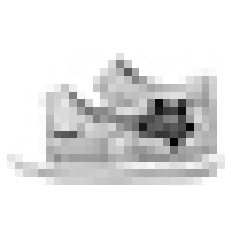

In [49]:
plt.axis('off')
_ = plt.imshow(x_test[ind], cmap=plt.cm.gray_r, interpolation='nearest')

In [50]:
print(class_names[np.argmax(pred_y[ind])])

Sandal
